In [1]:
import numpy as np
import time
import itertools
from pylab import *
from l2distance import l2distance
import numpy.random as random
#from RandomInteraction import get_magnet_pad
from calculate_energy import *
from visualization import show_pads

%load_ext line_profiler
from cvxopt.modeling import *
from cvxpy import *


In [2]:
def gen_3D_pos2(N, dlist):
    """
    generate pariwise Rxi^2 + Ryj^2 + d^2 between two N by N pads 
    INPUT:
    N, integer
    dlist: a list of distances
    OUTPUT:
    pos_list: a list of N^2 by N^2 array, ith array is pos + ith distance in dlist. 
    
    """
    pos = gen_2D_pos(N)
    N2 = N * N
    pos_list = np.zeros([len(dlist), N2, N2])
    for i in range(len(dlist)): 
        d_square = dlist[i] * dlist[i]
        R_square = pos + d_square 
        pos_array = ((R_square - 3 * d_square) / np.sqrt(R_square ** 5))
        pos_list[i] = pos_array
    return np.asfarray(pos_list,'float32')


def energy_by_distance(pad1, poslist, pad2):
    """
    INPUT:
    pads1: a 2D array, shape of M by N^2
    pads1: a 2D array, shape of M by N^2
    poslist: a 3D array, N^2 by N^2 by D, where D is the dimension for distances 
    OUTPUT:
    B, a 3D array, M by D
    """    
    A = np.dot(pad1, poslist)
    B = np.dot(A, pad2)
    return B

In [3]:
from line_profiler import LineProfiler
import numpy as np
def gen_problem(target, N, A, addnoise=True,sd=0.1):
    """
    INPUT: 
    target, a list of target values at different distances
    N, integer
    A, a list of interaction tensors at different distances
    
    OUTPUT:
    Pout, a N by 1 array
    Qout, a N by 1 array
    value, float, the difference between target and optimized results
    """
    N2 = N * N
    P = Variable((N2, 1),boolean=True)
    Q = Variable((N2, 1),boolean=True)
    
    W = []
    constraint = []
    

    for i in range(N2):
        W.append(Variable((N2, 1)))
        constraint.append(W[i] <= P[i] + Q)
        constraint.append(W[i] >= P[i] - Q)
        constraint.append(W[i] >= Q - P[i])
        constraint.append(W[i] <= 2 - P[i] - Q)
        
        
    objective = 0                   
    for d in range(len(target)):
        O=0.0
        for i in range(N2):

            O += multiply(( 1 - 2 * W[i]), A[d][i].reshape(N2,1))
           
            
        objective += sum_squares(sum(O) - target[d])

                       
    prob = Problem(Minimize(objective), constraint)
    prob.solve()
    Qout = Q.value.round(1)
    Pout = P.value.round(1)
    value = prob.value
    return Pout.reshape(-1)*2-1, Qout.reshape(-1)*2-1, value

N=2
dlist=np.arange(1,5,1)
pos2by2=np.asfarray(gen_3D_pos2(N, dlist),dtype='float32')
pad1 = get_magnet_pad(N,1)
pad2 = get_magnet_pad(N,4)
truth = energy_by_distance(pad1, pos2by2, pad2)
lp = LineProfiler()
lp_wrapper = lp(gen_problem)
lp_wrapper(truth, 2, pos2by2)
lp.print_stats()

Timer unit: 1e-06 s

Total time: 0.182941 s
File: <ipython-input-3-09362d9c2c4b>
Function: gen_problem at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def gen_problem(target, N, A, addnoise=True,sd=0.1):
     4                                               """
     5                                               INPUT: 
     6                                               target, a list of target values at different distances
     7                                               N, integer
     8                                               A, a list of interaction tensors at different distances
     9                                               
    10                                               OUTPUT:
    11                                               Pout, a N by 1 array
    12                                               Qout, a N by 1 array
    13                                               value,

In [4]:
print(installed_solvers())

['ECOS', 'ECOS_BB', 'CVXOPT', 'GLPK', 'GLPK_MI', 'SCS']


In [3]:
from line_profiler import LineProfiler
import numpy as np
def opt(target, N, A, renorm = None ,eps=100, maxiter=10):
    N2 = N * N
    P = Variable((N2, 1), boolean=True)
    Q = Variable((N2, 1), boolean=True)
    W = Variable((N2, N2))
    
    P_T_matrix = vstack([P.T] * N2)
    Q_matrix = hstack([Q] * N2)
    
    P_add_Q = P_T_matrix + Q_matrix
    p_sub_Q = P_T_matrix - Q_matrix
    
    constraint = []
    
    constraint.append(W <=  P_add_Q)
    constraint.append(W >=  p_sub_Q)
    constraint.append(W >= -p_sub_Q)
    constraint.append(W <= -P_add_Q + 2)
     
    objective = 0
    
    W_tmp = 1 - 2 * W
    maxe = np.max(target)
    for d in range(len(target)):
        if renorm is None:
            objective += sum_squares(sum(multiply(W_tmp, A[d])) - target[d])
        else:
            objective += sum_squares((sum(multiply(W_tmp, A[d])) - target[d]) / maxe)

        
        
    prob = Problem(Minimize(objective), constraint)
    err = 1000
    #while err > eps:
    #return prob
    
    prob.solve()
    err = prob.value
    besterr = prob.value
    bestQ = Q.value.round(1)
    bestP = P.value.round(1)
    iteration = 1
    while (err > eps):
        iteration += 1
        if (iteration > maxiter): break
        prob.solve(warm_start=True)
        err = prob.value
        if err > besterr:
            besterr = err
            bestQ = Q.value.round(1)
            bestP = P.value.round(1)
            
    #Qout = Q.value.round(1)
    #Pout = P.value.round(1)
    #value = prob.value
    print("err=",err, "iteration=", iteration)
    return bestP.reshape(-1)*2-1, bestQ.reshape(-1)*2-1, besterr
N=4
dlist=np.arange(1,5,1)
pos2by2=np.asfarray(gen_3D_pos2(N, dlist),dtype='float32')
pad1 = get_magnet_pad(N,1822)
pad2 = get_magnet_pad(N,35951)
truth = energy_by_distance(pad1, pos2by2, pad2)

#lp = LineProfiler()
#lp_wrapper = lp(opt)
#lp_wrapper(truth, N, pos2by2)
#lp.print_stats()       

In [4]:
import timeit
def opt(target, N, A, eps=100, maxiter=10):
    N2 = N * N
    P = Variable((N2, 1), boolean=True)
    Q = Variable((N2, 1), boolean=True)
    W = Variable((N2, N2))
    
    P_T_matrix = vstack([P.T] * N2)
    Q_matrix = hstack([Q] * N2)
    
    P_add_Q = P_T_matrix + Q_matrix
    p_sub_Q = P_T_matrix - Q_matrix
    
    constraint = []
    
    constraint.append(W <=  P_add_Q)
    constraint.append(W >=  p_sub_Q)
    constraint.append(W >= -p_sub_Q)
    constraint.append(W <= -P_add_Q + 2)
     
    objective = 0
    
    W_tmp = 1 - 2 * W
    
    for d in range(len(target)):
        objective += sum_squares(sum(multiply(W_tmp, A[d])) - target[d])
        
    prob = Problem(Minimize(objective), constraint)
    err = 1000
    #while err > eps:
    #return prob
    
    prob.solve()
    err = prob.value
    besterr = prob.value
    bestQ = Q.value.round(1)
    bestP = P.value.round(1)
    iteration = 1
    while (err > eps):
        iteration += 1
        if (iteration > maxiter): break
        prob.solve(warm_start=True)
        err = prob.value
        if err > besterr:
            besterr = err
            bestQ = Q.value.round(1)
            bestP = P.value.round(1)
            
    #Qout = Q.value.round(1)
    #Pout = P.value.round(1)
    #value = prob.value
    print("err=",err, "iteration=", iteration)
    return bestP.reshape(-1)*2-1, bestQ.reshape(-1)*2-1, besterr
N=4
dlist=np.arange(1,5,1)
pos2by2=np.asfarray(gen_3D_pos2(N, dlist),dtype='float32')
pad1 = get_magnet_pad(N,1822)
pad2 = get_magnet_pad(N,35951)
truth = energy_by_distance(pad1, pos2by2, pad2)

In [29]:
%timeit opt(truth, N, pos2by2, eps=0.001) 

err= 0.0009805689995770967 iteration= 1
err= 0.0009805689995770967 iteration= 1
err= 0.0009805689995770967 iteration= 7
err= 0.00012565958715311432 iteration= 9
err= 0.0009805689995770967 iteration= 7
err= 0.0009805689995770967 iteration= 1
err= 0.006088744425787585 iteration= 11
err= 0.00012565958715311432 iteration= 1
The slowest run took 10.23 times longer than the fastest. This could mean that an intermediate result is being cached.
1min 49s ± 1min 19s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
# generate two pads
# get_magnet_pad(N,m) gives the m th pad from 2^(N^2) combintaions
N=2
dlist=np.arange(1,5,1)
pos2by2=np.asfarray(gen_3D_pos2(N, dlist),dtype='float32')
pad1 = get_magnet_pad(N,1)
pad2 = get_magnet_pad(N,4)
truth = energy_by_distance(pad1, pos2by2, pad2)

In [ ]:
time.sleep(60)

[0.3626198  0.11051471 0.02493373 0.48337543]


NameError: name 'pos4by4' is not defined

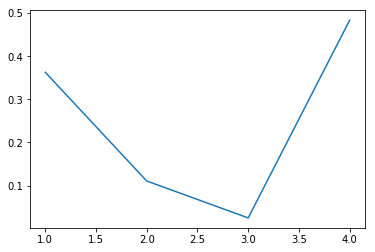

In [7]:
random_pes = np.random.rand(len(dlist))
print(random_pes)
plt.plot(dlist, random_pes)
for i in range(1):
    P,Q,err=gen_problem(random_pes, 4, pos4by4, addnoise=False)
    pred = energy_by_distance(P, pos4by4, Q)
    print(err)
    plot(dlist, pred)
#plot(dlist, truth)

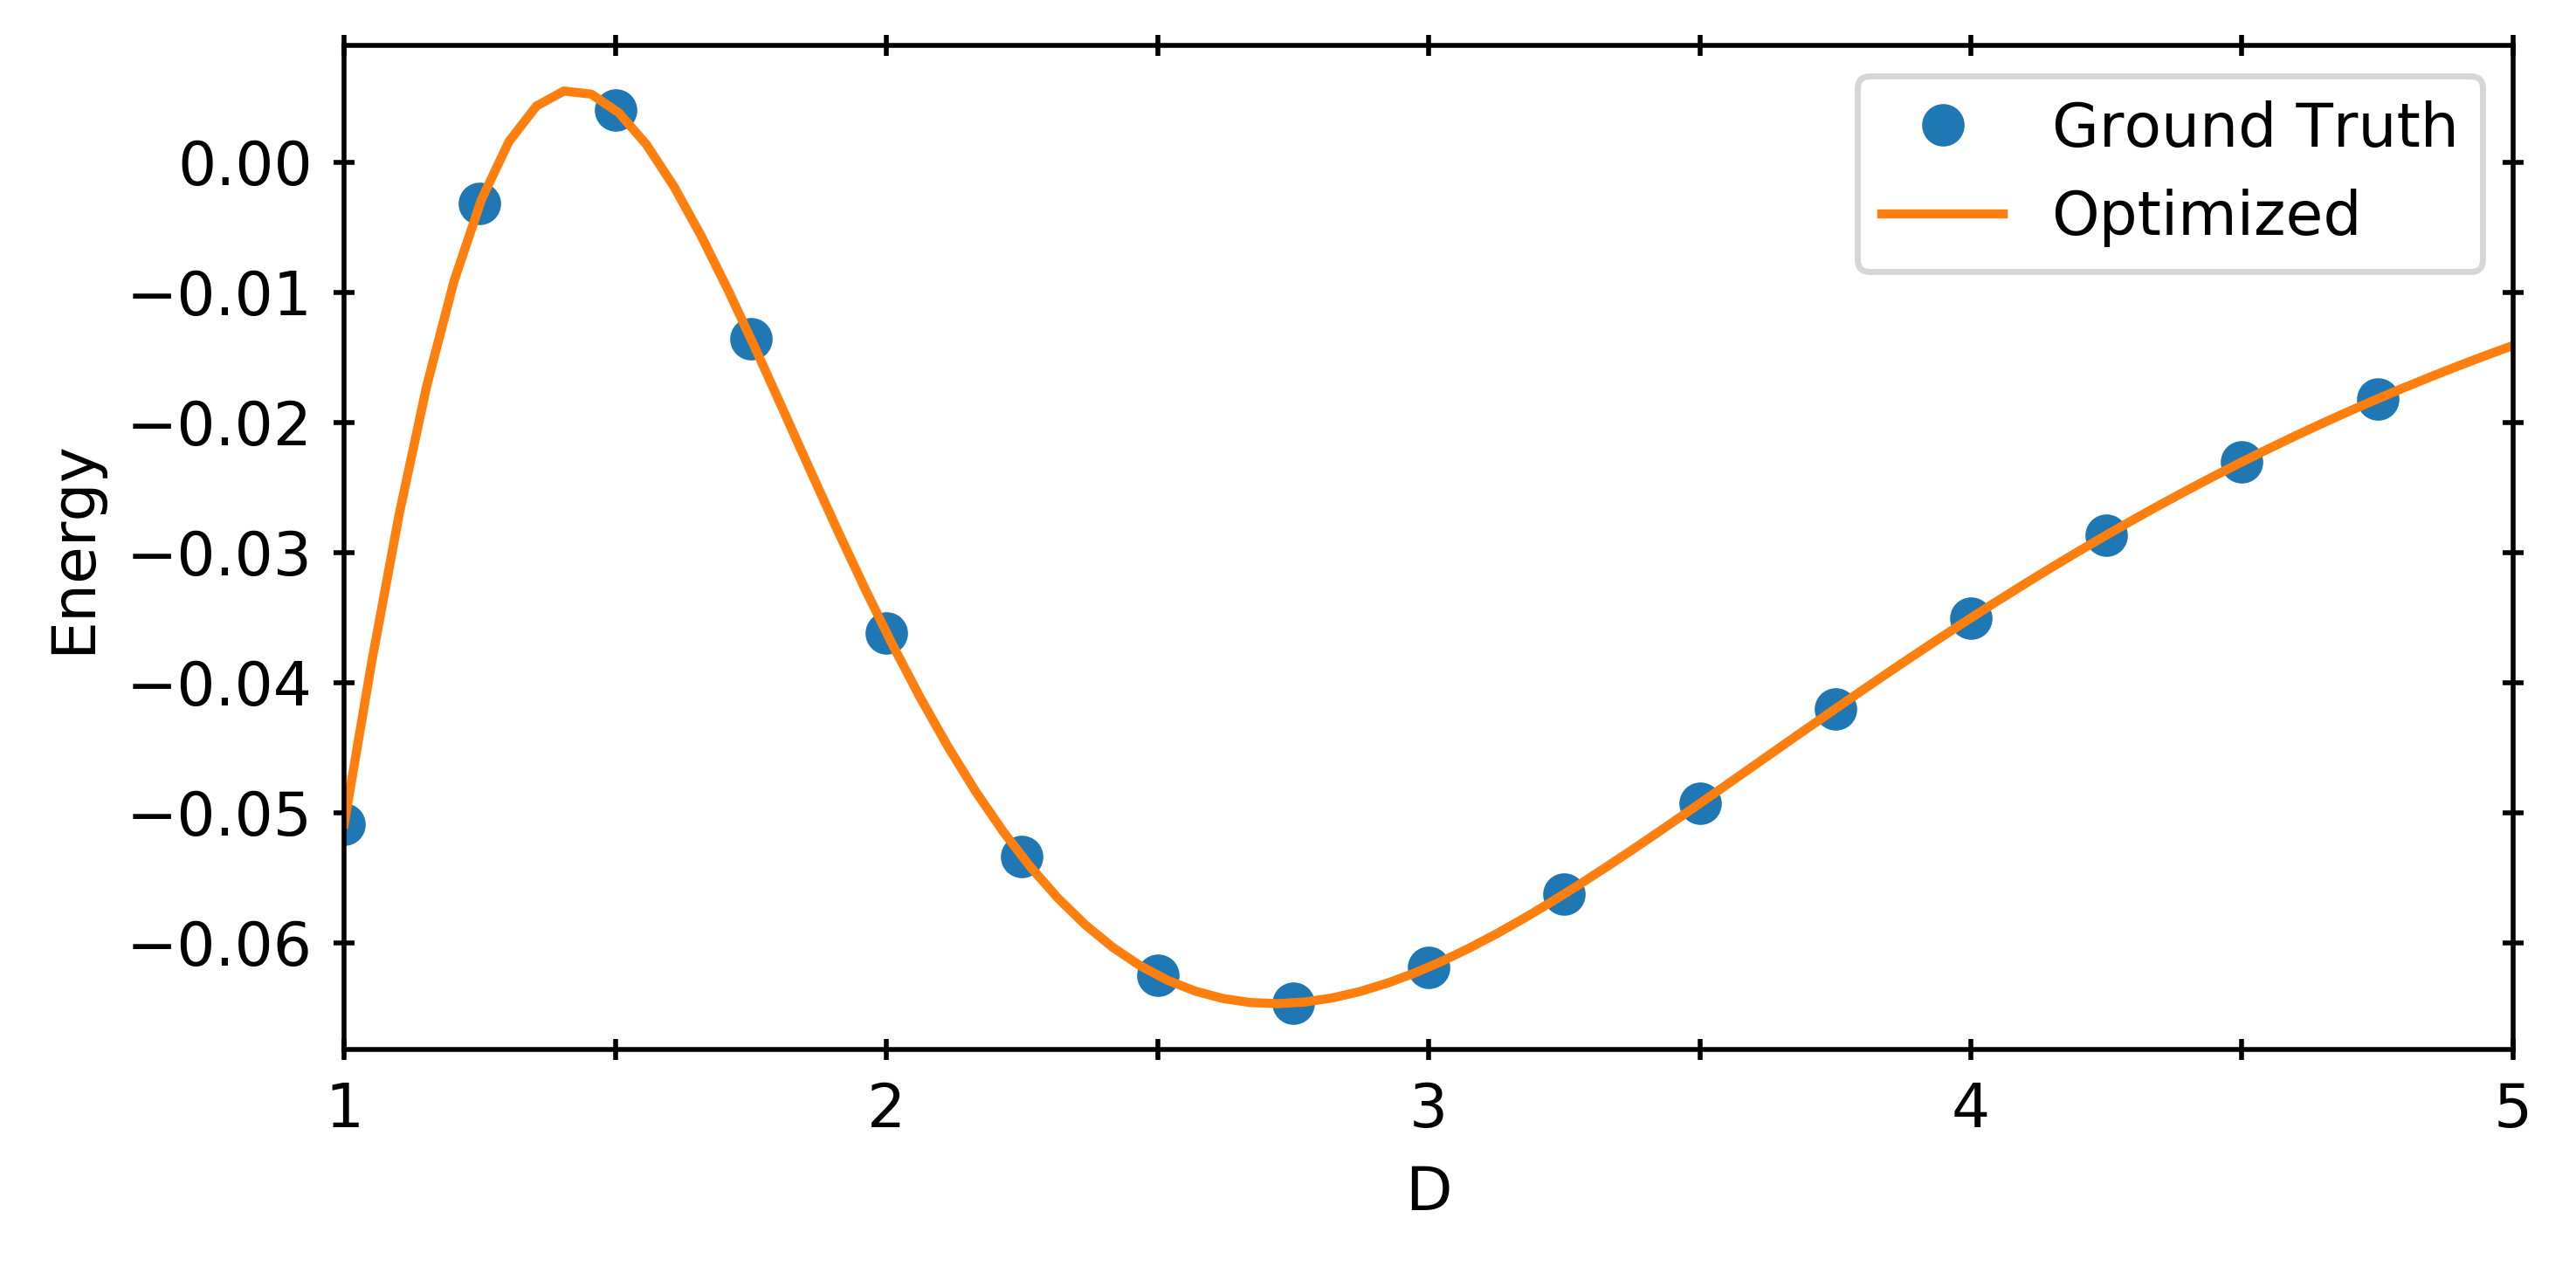

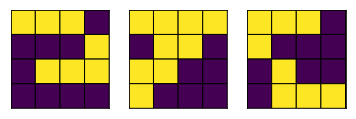

<Figure size 432x288 with 0 Axes>

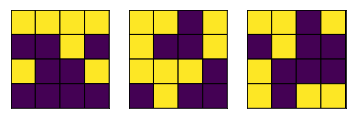

<Figure size 432x288 with 0 Axes>

In [21]:
N=4
pad1= np.array([1,1,1,-1,-1,-1,-1,1,-1,1,1,1,-1,-1,-1,-1])
pad2= np.array([1,1,1,1,-1,1,1,-1,1,1,-1,-1,1,-1,-1,-1])

pad1p= np.array([1,1,1,1,-1,-1,1,-1,1,-1,-1,1,-1,-1,-1,-1])
pad2p= np.array([1,1,-1,1,1,-1,-1,1,1,1,1,-1,-1,1,-1,-1])

dlist=np.linspace(1,5,80)
fig, ax = plt.subplots(figsize=(6,3),dpi=500)
ax.tick_params(axis="y",direction="inout", left="on",right='on',labelleft="on")
ax.tick_params(axis="x",direction="inout", top="on",labelleft="on")
#plt.figure(figsize=(4,3),dpi=200)
dlist2=np.arange(1,5,0.25)
poslist=np.asfarray(gen_3D_pos2(N, dlist),dtype='float32')
poslist2=np.asfarray(gen_3D_pos2(N, dlist2),dtype='float32')
truth = energy_by_distance(pad1,poslist2,pad2)
pred=energy_by_distance(pad1p,poslist,pad2p)
plot(dlist2,truth.reshape(len(dlist2)),label='Ground Truth',linewidth=0, marker = 'o')
plot(dlist,pred.reshape(len(dlist)),label='Optimized')
plt.xticks(np.linspace(1,5,9), ('1','', '2', ' ','3', ' ','4',' ', '5'))
plt.xlabel("D")
plt.ylabel("Energy")
plt.legend()
plt.xlim(1,5)

plt.tight_layout()
show_pads(pad1,pad2,N)
show_pads(pad1p,pad2p,N)

err= -2.5595301267489322e-12 iteration= 1
-2.5595301267489322e-12


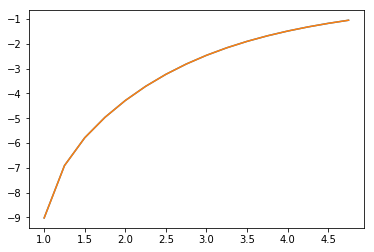

In [8]:
N=4
pad1 = get_magnet_pad(N,100)
pad2 = get_magnet_pad(N,400)
dlist=np.arange(1,5,0.25)
pos4by4=np.asfarray(gen_3D_pos2(4, dlist),dtype='float32')
truth = energy_by_distance(pad1, pos4by4, pad2)

for i in range(1):
    P,Q,err= opt(truth, N, pos4by4, renorm = "max" ,eps=100, maxiter=10)
    gen_problem(truth, 4, pos4by4, addnoise=False)
    pred = energy_by_distance(P, pos4by4, Q)
    print(err)
    plot(dlist, pred)
plot(dlist, truth)

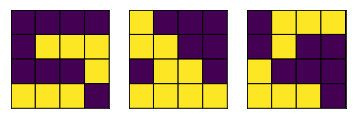

<Figure size 432x288 with 0 Axes>

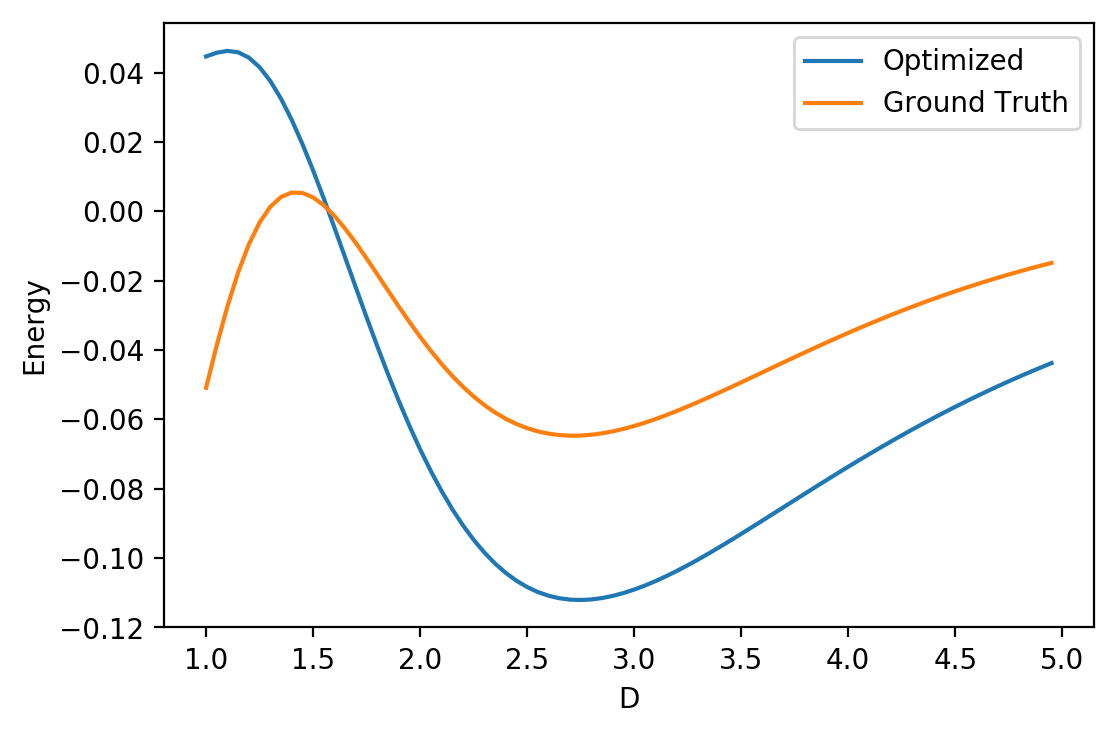

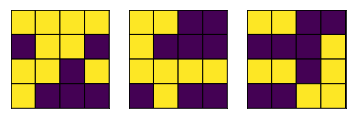

[ 1.  1.  1.  1. -1.  1.  1. -1.  1.  1. -1.  1.  1. -1. -1. -1.]
[ 1.  1. -1. -1.  1. -1. -1. -1.  1.  1.  1.  1. -1.  1. -1. -1.]
0.03137638911041907


<Figure size 432x288 with 0 Axes>

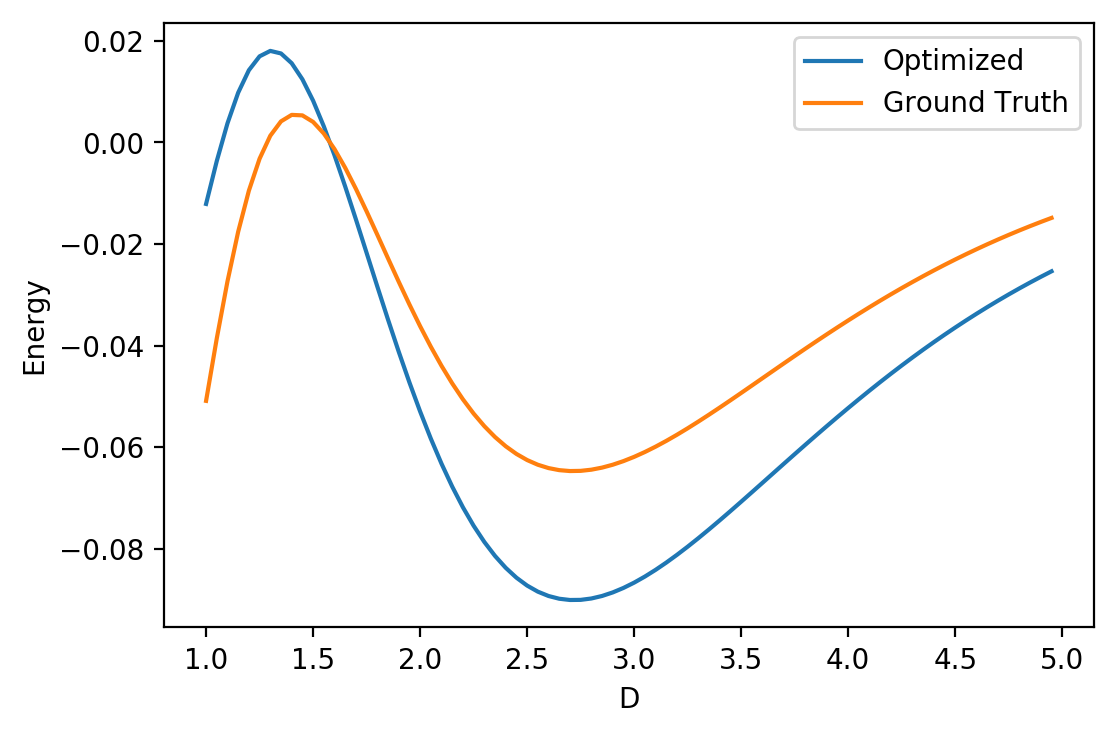

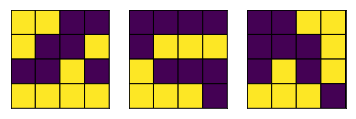

[ 1.  1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -1.  1.  1.  1.  1.]
[-1. -1. -1. -1. -1.  1.  1.  1.  1. -1. -1. -1.  1.  1.  1. -1.]
0.006852389486769543


<Figure size 432x288 with 0 Axes>

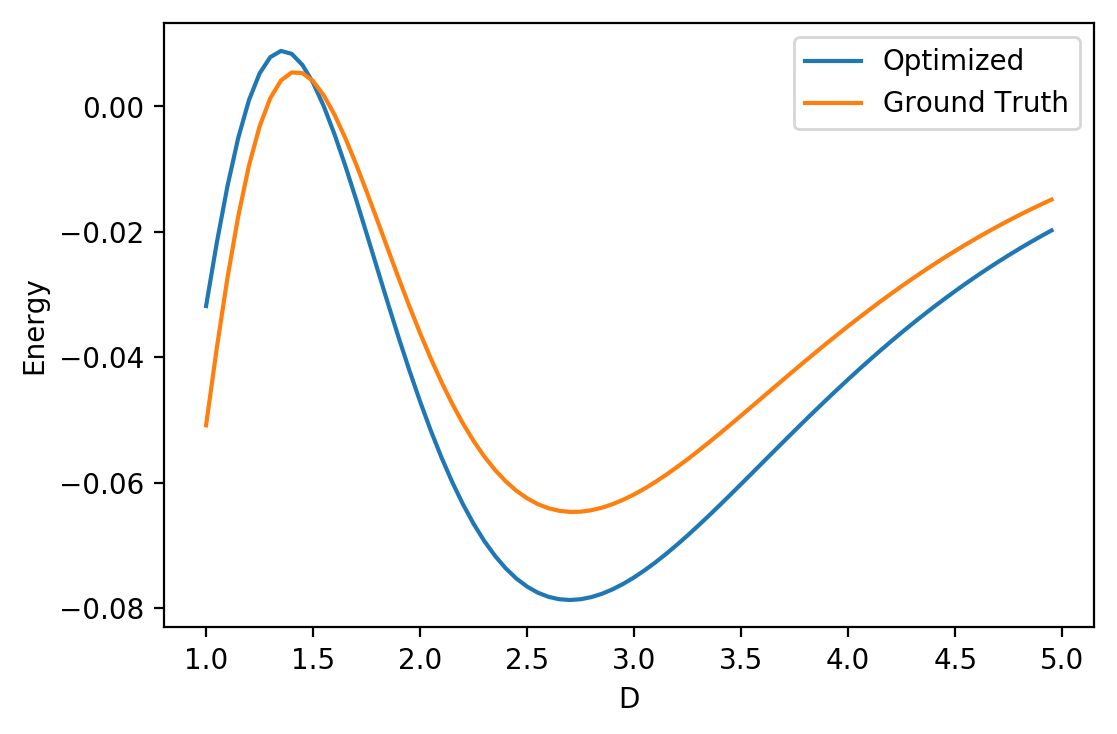

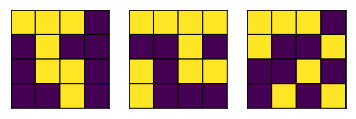

[ 1.  1.  1. -1. -1.  1. -1. -1. -1.  1.  1. -1. -1. -1.  1. -1.]
[ 1.  1.  1.  1. -1. -1.  1. -1.  1. -1.  1.  1.  1. -1. -1. -1.]
0.0019006077652972758


<Figure size 432x288 with 0 Axes>

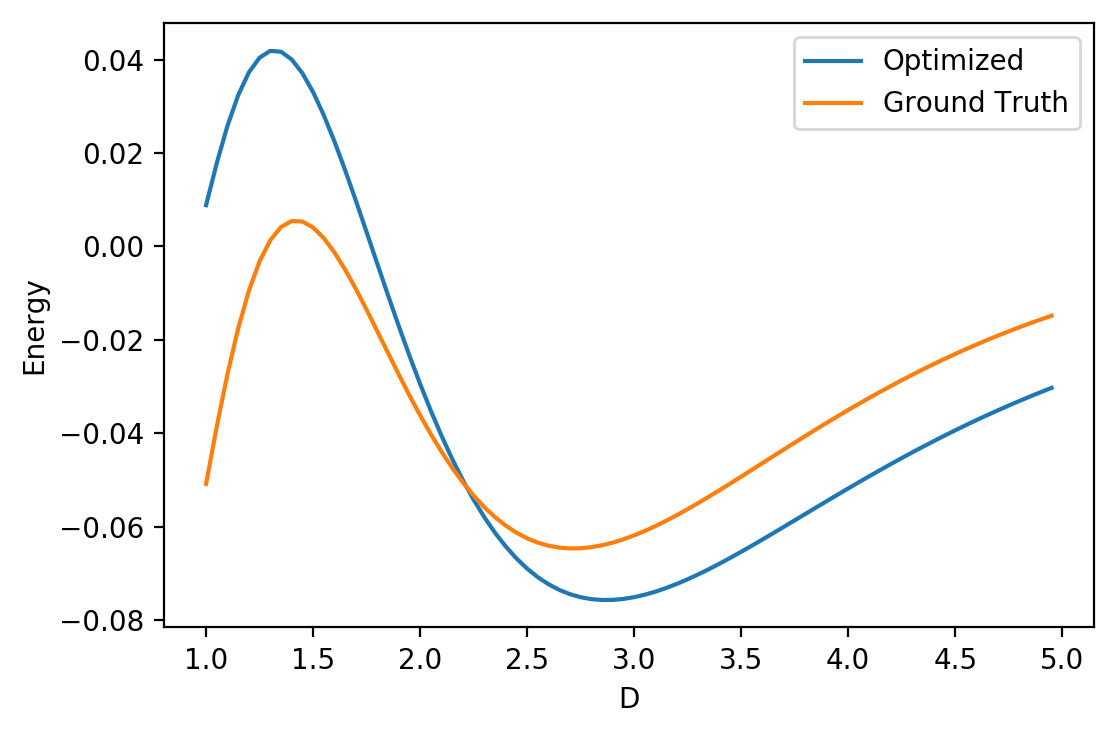

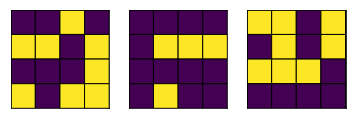

[-1. -1.  1. -1.  1.  1. -1.  1. -1. -1. -1.  1.  1. -1.  1.  1.]
[-1. -1. -1. -1. -1.  1.  1.  1. -1. -1. -1. -1. -1.  1. -1. -1.]
0.008798901627202878


<Figure size 432x288 with 0 Axes>

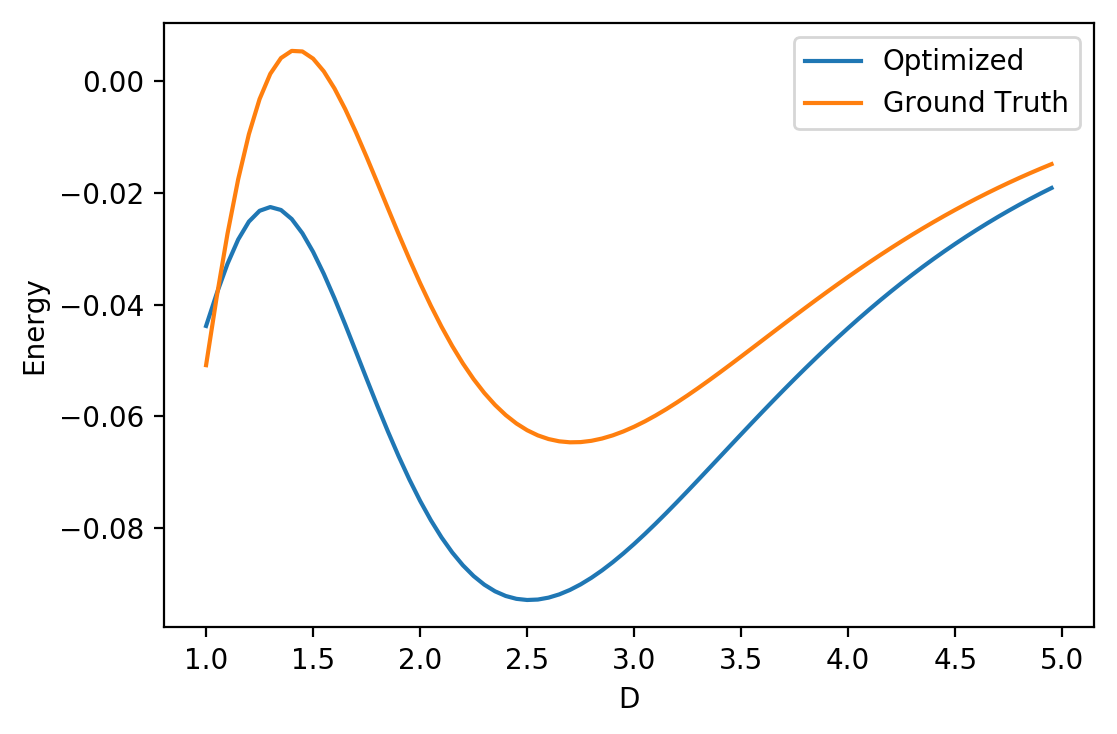

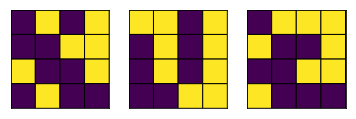

[-1.  1. -1.  1. -1. -1.  1.  1.  1. -1. -1.  1. -1.  1. -1. -1.]
[ 1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1. -1.  1.  1.]
0.008824852710488267


<Figure size 432x288 with 0 Axes>

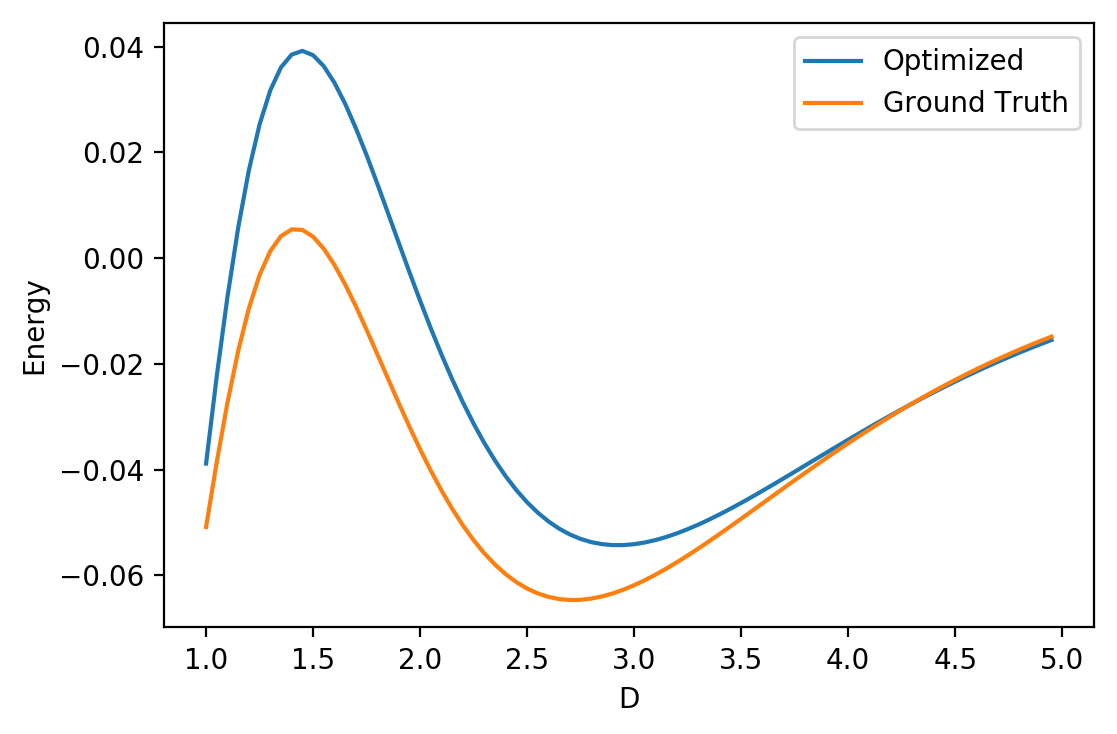

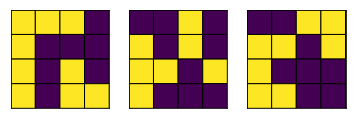

[ 1.  1.  1. -1.  1. -1. -1. -1.  1. -1.  1. -1.  1. -1.  1.  1.]
[-1. -1.  1. -1.  1. -1.  1. -1.  1.  1. -1.  1.  1. -1. -1. -1.]
0.004998858773583764


<Figure size 432x288 with 0 Axes>

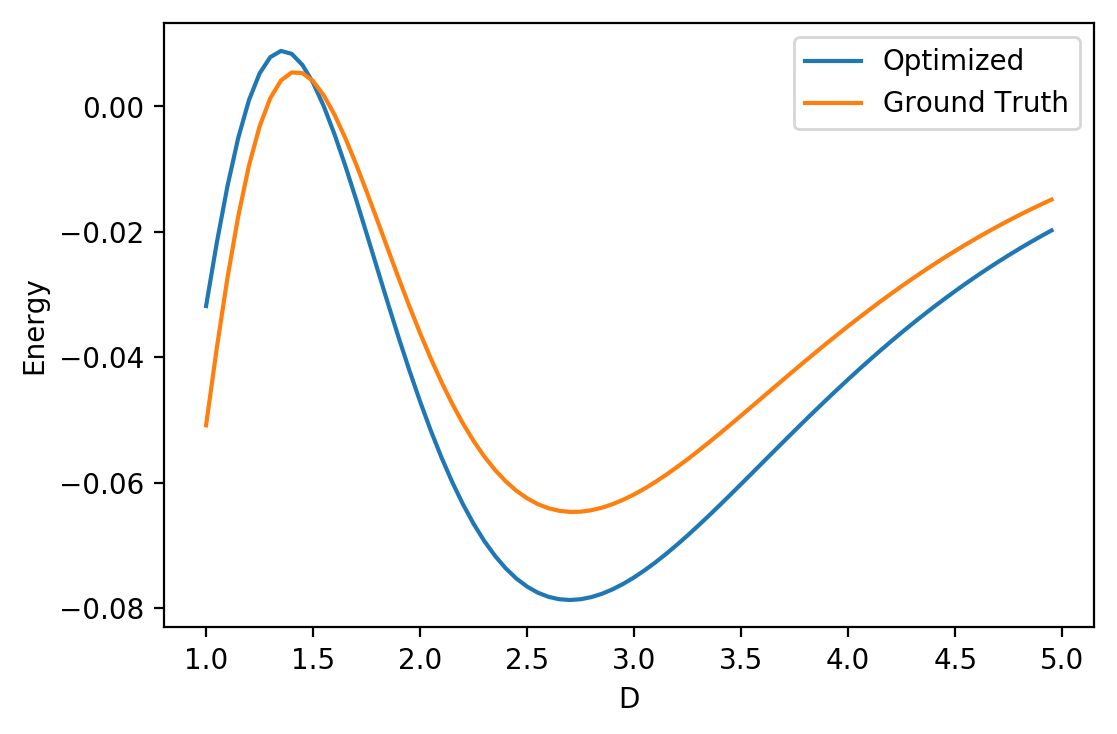

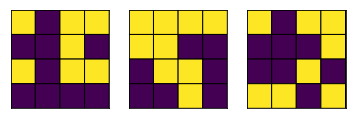

[ 1. -1.  1.  1. -1. -1.  1. -1.  1. -1.  1.  1. -1. -1. -1. -1.]
[ 1.  1.  1.  1.  1.  1. -1. -1. -1.  1.  1. -1. -1. -1.  1. -1.]
0.001900607765197278


<Figure size 432x288 with 0 Axes>

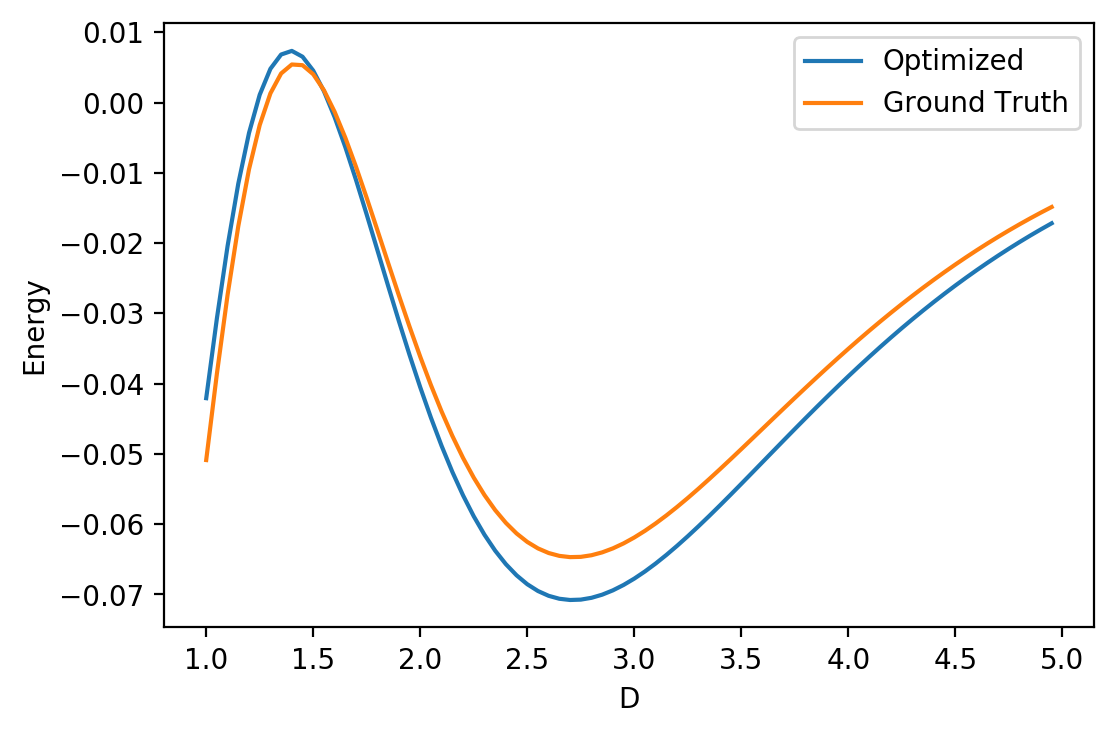

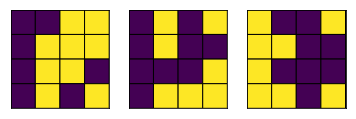

<Figure size 432x288 with 0 Axes>

In [8]:
N=4
pad1= 1822
pad2= 35951
dlist=np.arange(1,5,0.25)
dlist2=np.arange(1,5,0.05)
poslist=np.asfarray(gen_3D_pos2(N, dlist),dtype='float32')
poslist2=np.asfarray(gen_3D_pos2(N, dlist2),dtype='float32')
truth = energy_by_distance(get_magnet_pad(N, pad1),poslist,get_magnet_pad(N, pad2))
truthnew=energy_by_distance(get_magnet_pad(N, pad1),poslist2,get_magnet_pad(N, pad2))
#plot(dlist,truth.reshape(len(dlist)),label='Ground Truth')
show_pads(get_magnet_pad(N, pad1),get_magnet_pad(N, pad2),N)
for i in range(10):
    P,Q,err=gen_problem(truth,4, poslist,addnoise=False)
    
    pred = energy_by_distance(P, poslist, Q)
    plt.figure(figsize=(6,4),dpi=200)
    prednew=energy_by_distance(P, poslist2, Q)
    
    plot(dlist2,prednew.reshape(len(dlist2)),label='Optimized')
    plot(dlist2,truthnew.reshape(len(dlist2)),label='Ground Truth')
    plt.xlabel("D")
    plt.ylabel("Energy")
    plt.legend()
    show_pads(P,Q,4)
    if err < 0.0005:
        break
    print(P)
    print(Q)
    print(err)


In [ ]:
  
N=5
pad1 = 20349863
pad2 = 6547718
dlist=np.arange(1.5,8,0.05)
poslist=np.asfarray(gen_3D_pos2(N, dlist),dtype='float32')
truth = energy_by_distance(get_magnet_pad(N, pad1),poslist,get_magnet_pad(N, pad2))
plot(dlist,truth.reshape(len(dlist)))


for i in range(5):
    P,Q,err=gen_problem(truth,N, poslist,addnoise=False)
    pred = energy_by_distance(P, poslist, Q)
 
    plot(dlist,pred.reshape(len(dlist)))
    plot(dlist,truth.reshape(len(dlist)))
    show_pads(P,Q,N)
    print(err)

